![Py4Eng](img/logo.png)

# Autoencoders
## Yoav Ram

An autoencoder is a model that encodes an image to its features, and then decoded the features back to the (original) image. This is useful for a variety of applications, such as lossy compression, data generation, and unsupervised feature learning.

![autoencoder](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

We will create a simple autoencoder using FFN, but more examples are [available](https://blog.keras.io/building-autoencoders-in-keras.html).



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

import tensorflow as tf
import keras

print('Tensorflow:', tf.__version__)    
print('Keras:', keras.__version__)
print('GPU:', tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

sns.set(
    style='ticks',
    context='talk',
    palette='Set1'
)

def display_image(im):
    fig, ax = plt.subplots()
    ax.imshow(im, cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])    

2023-11-08 23:23:02.233542: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow: 2.13.1
Keras: 2.13.1
GPU: []



We first load the MNIST dataset.

In [2]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
nsamples, width, height = X_train.shape
X_train = (X_train/255).astype('float32')
X_test = (X_test/255).astype('float32')

In [3]:
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)
ncats = Y_test.shape[1]

We start with the **encoder**, which encodes a 28x28 image to a features vector of length 32.

In [4]:
# this is the size of our encoded representations
# compression of factor 24.5
nfeatures = 32  

encoder = keras.Sequential([
    keras.layers.Flatten(input_shape=(width, height)),
    keras.layers.Dense(nfeatures, activation='tanh')
])

The **decoder** decoded the features vector back to an image.

In [5]:
decoder = keras.Sequential([
    keras.layers.Dense(width * height, activation='sigmoid', input_shape=(nfeatures,)),
    keras.layers.Reshape(target_shape=(width, height))
])  

Now the **autoencoder** encodes an image and decoed it back using the encoder and decoder. This is where we apply the functional API.

In [6]:
input_image = keras.Input(shape=(width, height))
encoded = encoder(input_image)
decoded = decoder(encoded)

autoencoder = keras.Model(input_image, decoded)

We compile the autoencoder so we can train it on reconstructing images.

In [7]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Now we train the autoencoder.

In [8]:
history = autoencoder.fit(X_train, X_train, # Y=X
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test)).history

Epoch 1/50
235/235 [==============================] - 2s 6ms/step - loss: 0.3367 - val_loss: 0.2713
Epoch 2/50
235/235 [==============================] - 1s 6ms/step - loss: 0.2676 - val_loss: 0.2652
Epoch 3/50
235/235 [==============================] - 1s 6ms/step - loss: 0.2647 - val_loss: 0.2639
Epoch 4/50
235/235 [==============================] - 1s 6ms/step - loss: 0.2639 - val_loss: 0.2633
Epoch 5/50
235/235 [==============================] - 1s 6ms/step - loss: 0.2635 - val_loss: 0.2630
Epoch 6/50
235/235 [==============================] - 2s 7ms/step - loss: 0.2625 - val_loss: 0.2581
Epoch 7/50
235/235 [==============================] - 2s 7ms/step - loss: 0.2544 - val_loss: 0.2515
Epoch 8/50
235/235 [==============================] - 2s 7ms/step - loss: 0.2499 - val_loss: 0.2465
Epoch 9/50
235/235 [==============================] - 2s 7ms/step - loss: 0.2426 - val_loss: 0.2393
Epoch 10/50
235/235 [==============================] - 2s 7ms/step - loss: 0.2376 - val_loss: 0.2359

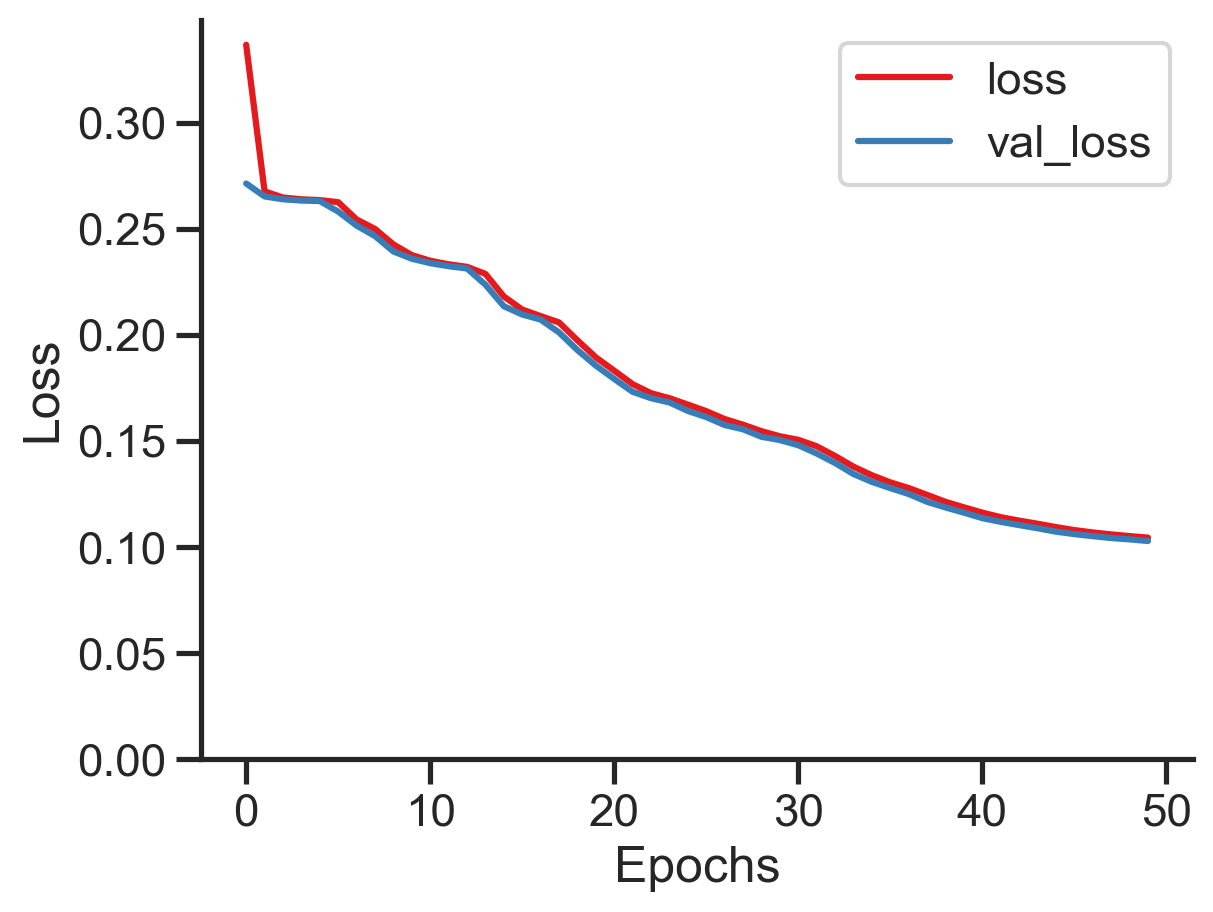

In [9]:
for k in history.keys():
    plt.plot(history[k], label=k)
plt.legend()
plt.ylim(0, None)
plt.xlabel('Epochs')
plt.ylabel('Loss')
sns.despine()

Save the models.

In [11]:
autoencoder.save('../data/autoencoder.keras')
encoder.save('../data/encoder.keras')
decoder.save('../data/decoder.keras')

Load the models.

In [12]:
autoencoder = keras.models.load_model('../data/autoencoder.keras')
encoder = keras.models.load_model('../data/encoder.keras')
decoder = keras.models.load_model('../data/decoder.keras')

Let's see how the autoencoder performs by encoding and decoding some digits.

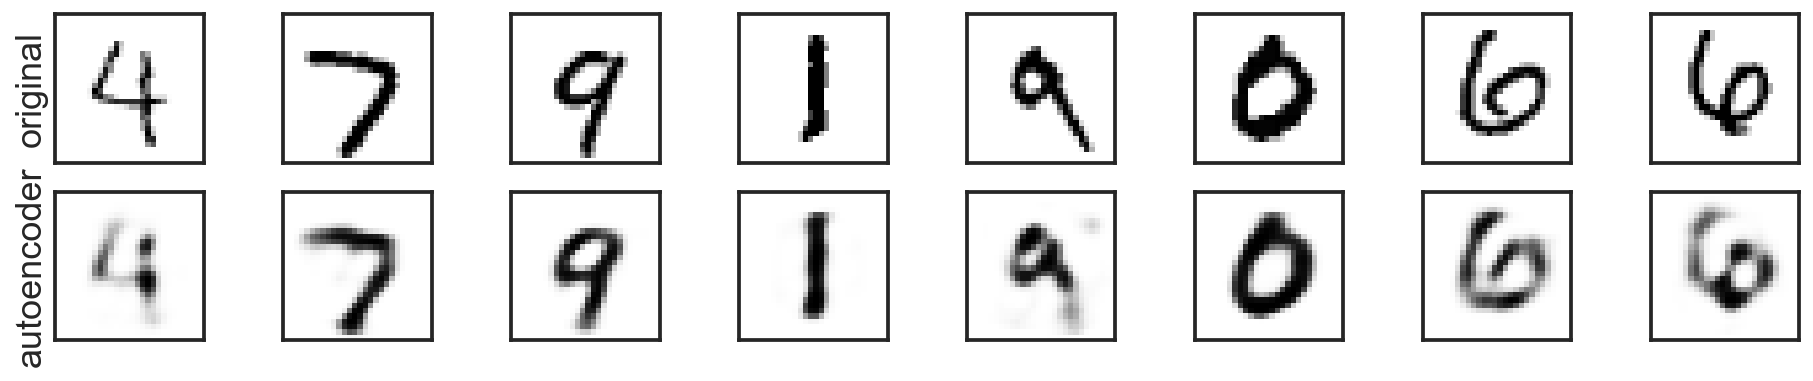

In [106]:
fig, axes = plt.subplots(2, 8, figsize=(16, 3), sharex=True, sharey=True)
for j in range(axes.shape[1]):
    i = np.random.choice(X_test.shape[1])
    im = X_test[i]
    axes[0, j].imshow(im, cmap='gray_r')
    im_ = autoencoder.predict(im.reshape((1, width, height))).squeeze()
    axes[1, j].imshow(im_, cmap='gray_r')
axes[0,0].set(xticks=[], yticks=[], ylabel='original')
axes[1,0].set(ylabel='autoencoder');

We can use the decoder to try to understand the features. We take the features of a specific image and modify them one by one, then decode them and look at the image.
Can you interpret some of the featrues?

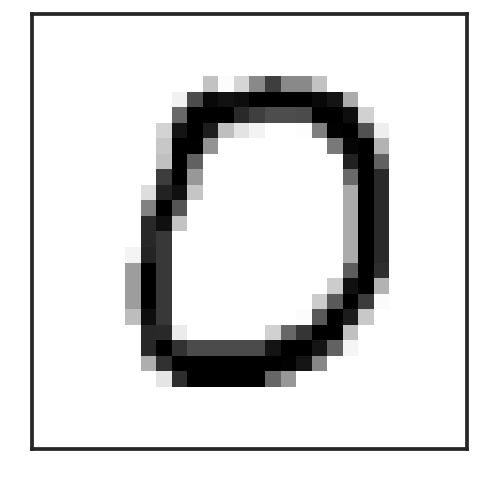

In [138]:
im = X_test[10]
display_image(im)

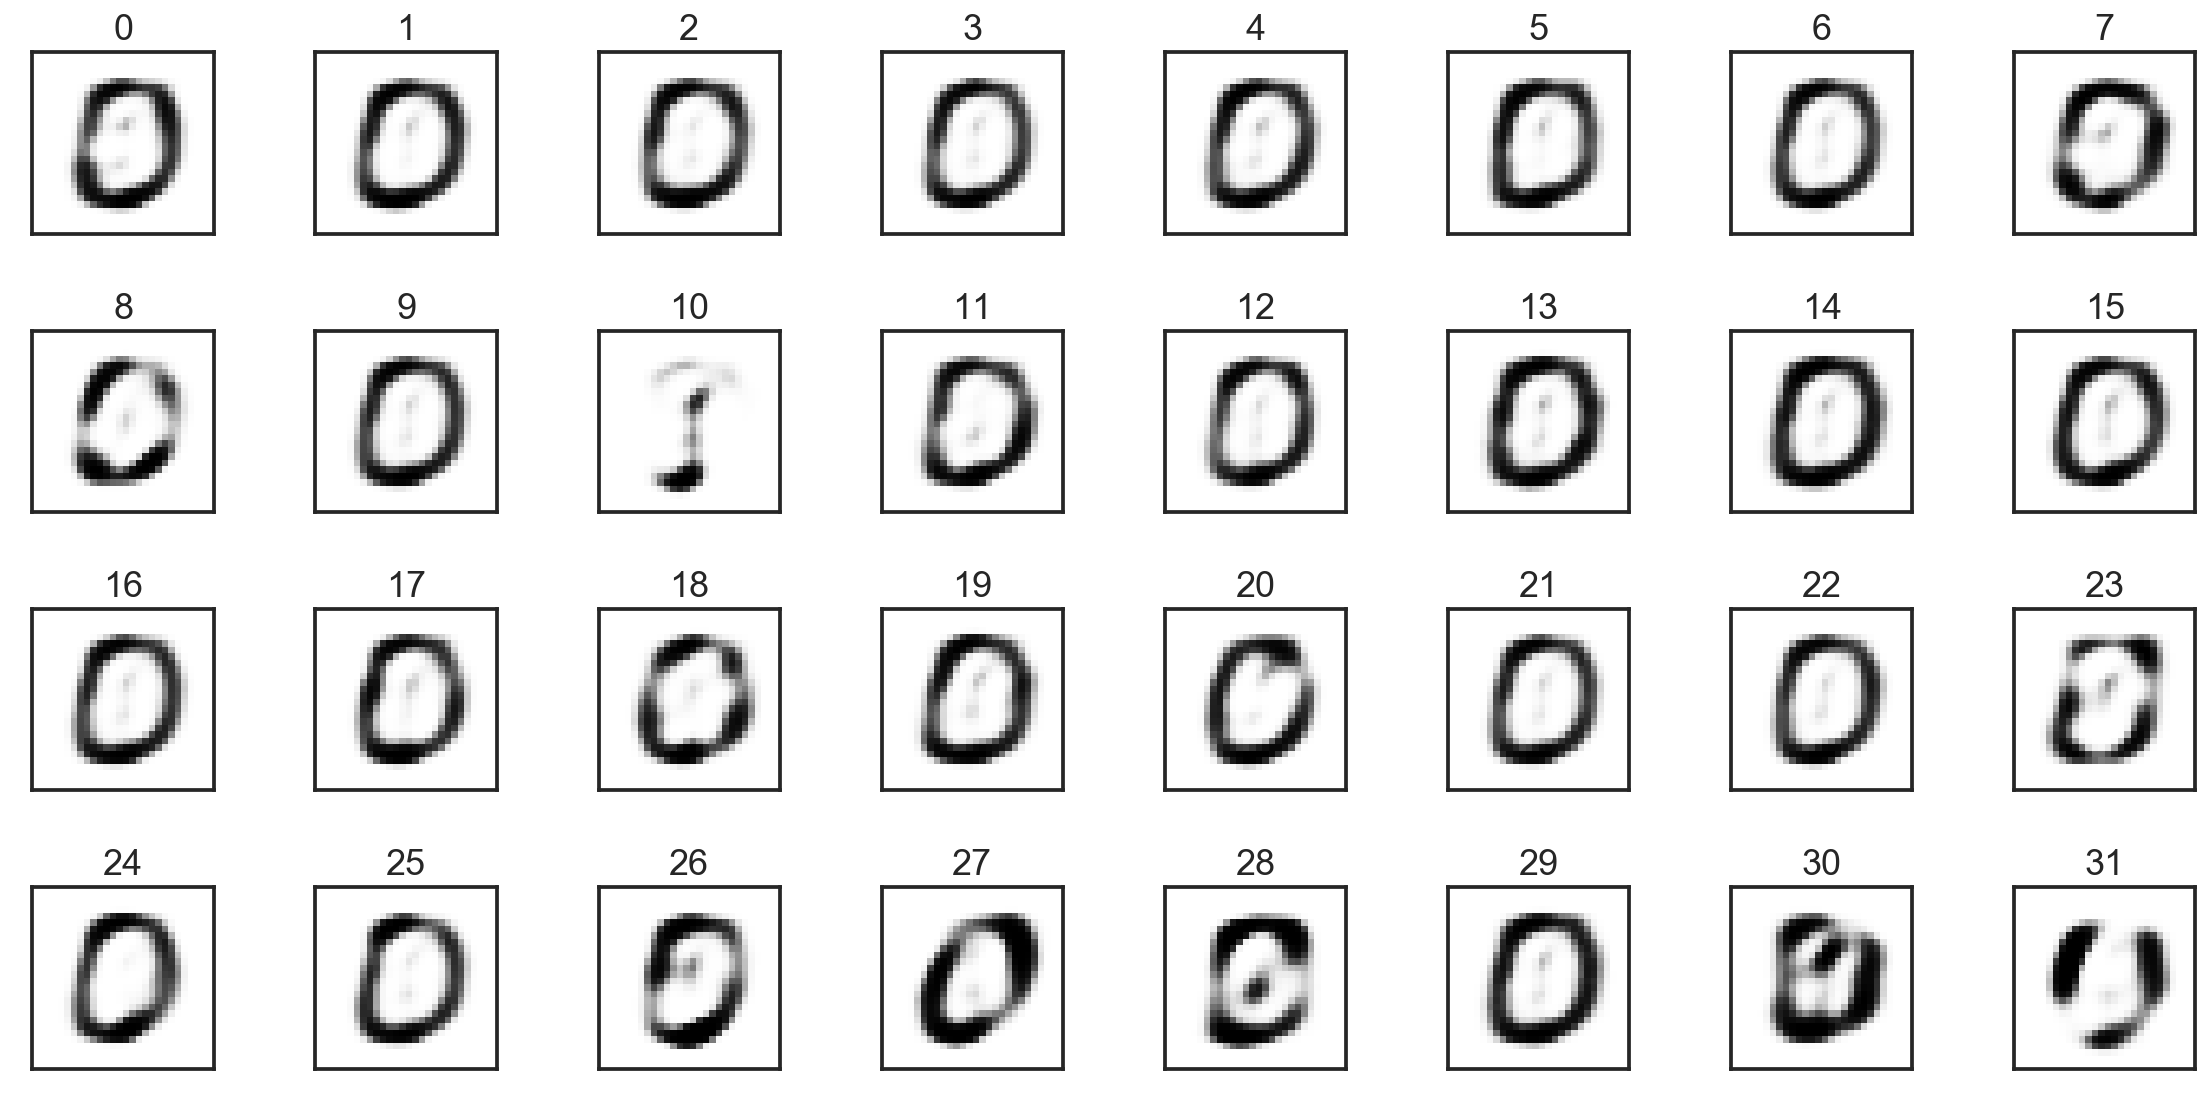

In [143]:
features = encoder.predict(im.reshape((1, width, height)))

fig, axes = plt.subplots(4, 8, figsize=(8*2, 4*2), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    features_ = features.copy()
    features_[0, i] = 1
    im_ = decoder.predict(features_).squeeze()
    ax.imshow(im_, cmap='gray_r')
    ax.set_title(i)
axes[0,0].set(xticks=[], yticks=[])
fig.tight_layout()

Autoencoders can be used for denoising; but in this case it would be better to train the autoencoder on denoising, that is, on reconstructing X from noisy X.

In [168]:
X_noise = X_test[:8] + np.random.normal(loc=0.0, scale=0.1, size=X_test[:8].shape) 
X_noise = X_test[:8].copy() 
r = np.random.random(X_noise.shape)
X_noise[r <= 0.02] = 0
X_noise[(0.02 < r) & (r <= 0.04)] = 1
X_denoised = autoencoder.predict(X_noise)

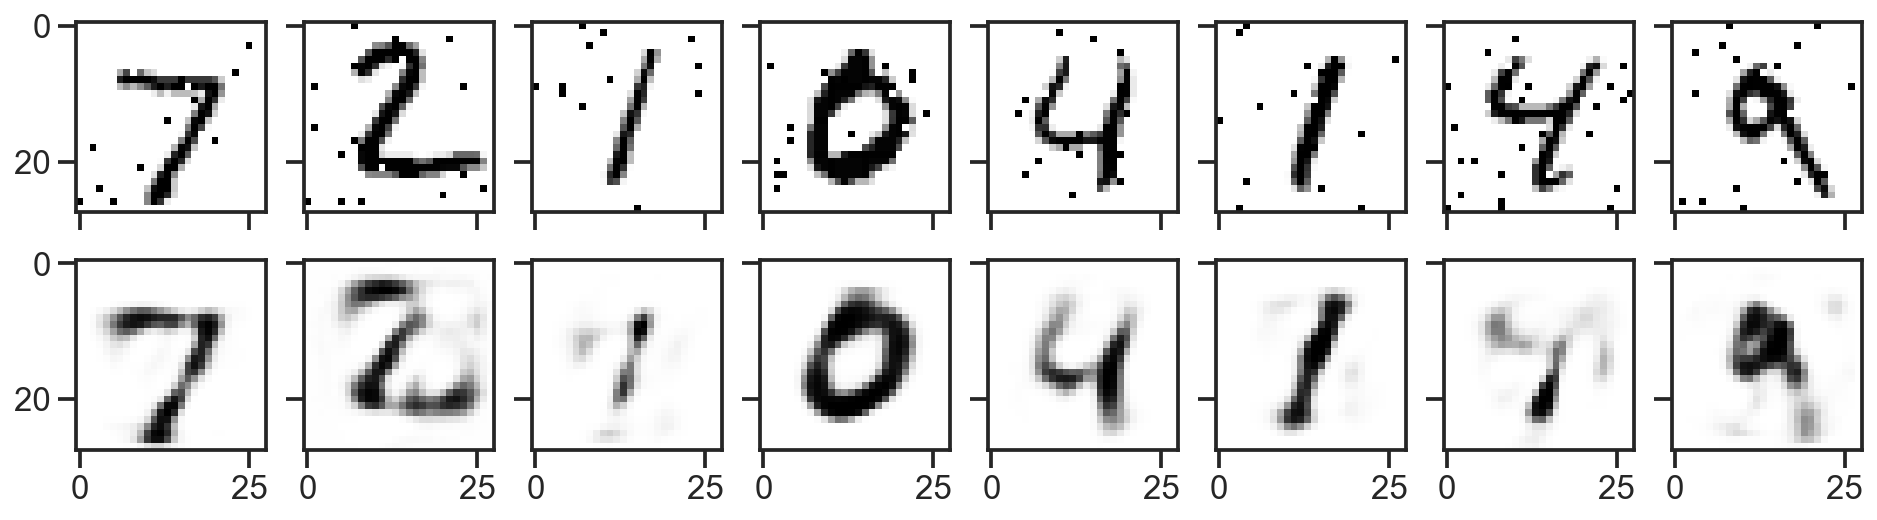

In [169]:
fig, axes = plt.subplots(2, X_noise.shape[0], figsize=(16, 4), sharex=True, sharey=True)
for j in range(X_noise.shape[0]):
    axes[0, j].imshow(X_noise[j], cmap='gray_r')
    axes[1, j].imshow(X_denoised[j], cmap='gray_r')

Another use for autoencoders is if we had many images (X) but only had labels (Y) for a few images. In this case we could learn how to encode images to features (i.e. train an encoder) using all the image data, and then compose a classifier on top of the encoder and train it with the limited number of labels we have.

# References

- Keras autoencoders [examples](https://blog.keras.io/building-autoencoders-in-keras.html).

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)